# Load Models and Data

In [1]:
%load_ext autoreload
%autoreload 2

import torch
from torch_geometric.loader import DataLoader
from torch_geometric.data import Dataset, Data  
from data_utils import *
from tqdm import tqdm
import pandas as pd

import networkx as nx
import torch_geometric.utils as pyg_utils

import seaborn as sns
import matplotlib.pyplot as plt

from rdkit import RDLogger
lg = RDLogger.logger()
lg.setLevel(RDLogger.CRITICAL)

from data_utils import *
from graph_vae.vae import GraphVAE

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# old: ./checkpoints/graph_vae_20240416_221922.pt  homo,lumo,r2
# ./checkpoints/graph_vae_20240502_125508.pt homo,lumo,r2
model = GraphVAE.from_pretrained(checkpoint_path="./checkpoints/graph_vae_20240508_221500.pt").to(device)
model.eval()
# old: ./checkpoints/graph_vae_20240416_225315.pt
#model_split = GraphVAE.from_pretrained(checkpoint_path="./checkpoints/graph_vae_20240508_153248.pt").to(device)
#model_split.eval()

#model = model_split

include_hydrogen = False

prop_norm_df = create_or_load_property_norm_df()

# create dataset and dataloaders
dataset = create_qm9_dataset(
    device=device, 
    include_hydrogen=False,
    refresh_data_cache=False,
    properties=model.properties,
    prop_norm_df=prop_norm_df
)

batch_size = 256
loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

# load training data smiles with properties to get the true properties of generated molecules
full_loader = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=False)
dataset_smiles_with_prop = dict()
for batch in tqdm(full_loader, desc="Converting dataset graphs to SMILES"):
    for sample_index in range(len(batch)):
        sample = batch[sample_index]
        mol = graph_to_mol(data=sample, includes_h=include_hydrogen, validate=False)
        dataset_smiles_with_prop[Chem.MolToSmiles(mol)] = model.denormalize_properties(sample.y)

Converting dataset graphs to SMILES: 100%|██████████| 501/501 [03:51<00:00,  2.16it/s]


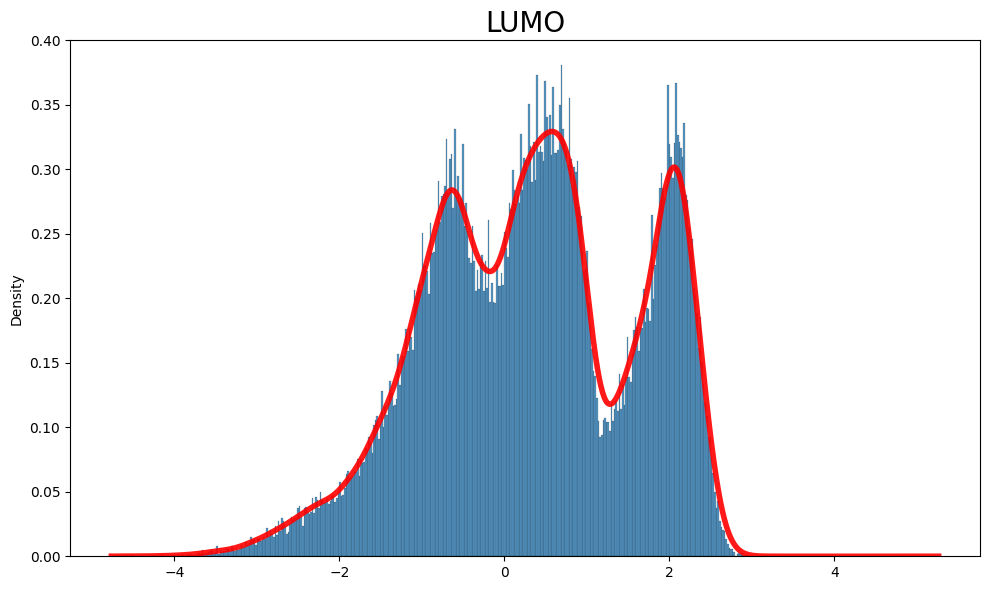

In [2]:
from scipy.stats import gaussian_kde

y_list = [y for y in dataset_smiles_with_prop.values()]
y = torch.cat(y_list, dim=0)
num_properties = len(model.properties)

fig, axes = plt.subplots(nrows=1, ncols=num_properties, figsize=(10 * num_properties, 6))
if num_properties == 1:
    axes = [axes]

x_d_list = []
density_dataset_list = []
for i, property in enumerate(model.properties):
    data = y[:, i].cpu().numpy()
    kde = gaussian_kde(data)
    x_d = np.linspace(np.min(data), np.max(data), 1000)
    x_d_list.append(x_d)
    density = kde(x_d)
    density_dataset_list.append(density)
    
    sns.histplot(data, bins=512, kde=False, stat='density', ax=axes[i])
    axes[i].plot(x_d, density, color='red', linewidth=4, alpha=0.9)
    axes[i].set_title(property.upper(), fontsize=20)

plt.tight_layout()
plt.show()

In [15]:
import pyro
import pyro.distributions as dist
from pyro.infer import MCMC, NUTS

y_target = torch.tensor(data=[-2], device=device).unsqueeze(0)
#y_target = torch.tensor(data=[-8.1, -1.98, 1628.67], device=device).unsqueeze(0)
#y_target = torch.tensor(data=[-5, -3, 800], device=device).unsqueeze(0)
y_target_norm = model.normalize_properties(y=y_target)


def pyro_model(y_obs):
    z = pyro.sample("z", dist.Normal(torch.zeros(model.property_z_size, device=device), torch.ones(model.property_z_size, device=device))).unsqueeze(0)

    y_mu, y_sigma = model.predict_properties(z)

    with pyro.plate("data"):
        pyro.sample("obs", dist.Normal(y_mu, y_sigma), obs=y_obs)


# Define the MCMC kernel, here using NUTS, which is good for continuous parameters
nuts_kernel = NUTS(pyro_model)

sample_count = 1500

# Run the MCMC sampler
mcmc = MCMC(nuts_kernel, num_samples=sample_count, warmup_steps=500)
mcmc.run(y_obs=y_target_norm)  # replace with your actual observed data

# Get the posterior samples
posterior_samples = mcmc.get_samples()

Sample: 100%|██████████| 2000/2000 [02:51, 11.68it/s, step size=3.09e-01, acc. prob=0.859]


In [16]:
class GeneratedDataset(Dataset):
    def __init__(self, data_list):
        super().__init__()
        self.data_list = data_list

    def len(self):
        return len(self.data_list)

    def get(self, idx):
        return self.data_list[idx]


# decode posterior samples
if model.latent_dim != model.property_z_size:
    z_prop = posterior_samples["z"]
    random_part = torch.randn(z_prop.shape[0], model.latent_dim - model.property_z_size, device=device)
    z = torch.cat((z_prop, random_part), dim=1)
else:
    z = posterior_samples["z"]

x = model.decode(z=z)

dataset_mol_count = 0
y_sample_list = []
valid_count = 0
data_list = []
for i in tqdm(range(sample_count)):
    sample_matrices = (x[0][i:i+1], x[1][i:i+1], x[2][i:i+1])

    for _ in range(32):
        sample_graph = model.output_to_graph(x=sample_matrices, stochastic=True)

        # Check if the generated graph is connected
        if not nx.is_connected(pyg_utils.to_networkx(sample_graph, to_undirected=True)):
            continue

        try:
            mol = graph_to_mol(data=sample_graph, includes_h=include_hydrogen, validate=True)
        except Exception as e:
            # Molecule is invalid; try to decode again
            continue

        # Molecule is valid
        if mol:
            data_list.append(sample_graph)

            smiles = Chem.MolToSmiles(mol)
            if smiles in dataset_smiles_with_prop:
                y_sample_list.append(dataset_smiles_with_prop[smiles])
                dataset_mol_count += 1
                
generated_dataset = GeneratedDataset(data_list=data_list)
print(dataset_mol_count)

  0%|          | 0/1500 [00:00<?, ?it/s]

100%|██████████| 1500/1500 [01:51<00:00, 13.43it/s]

5889


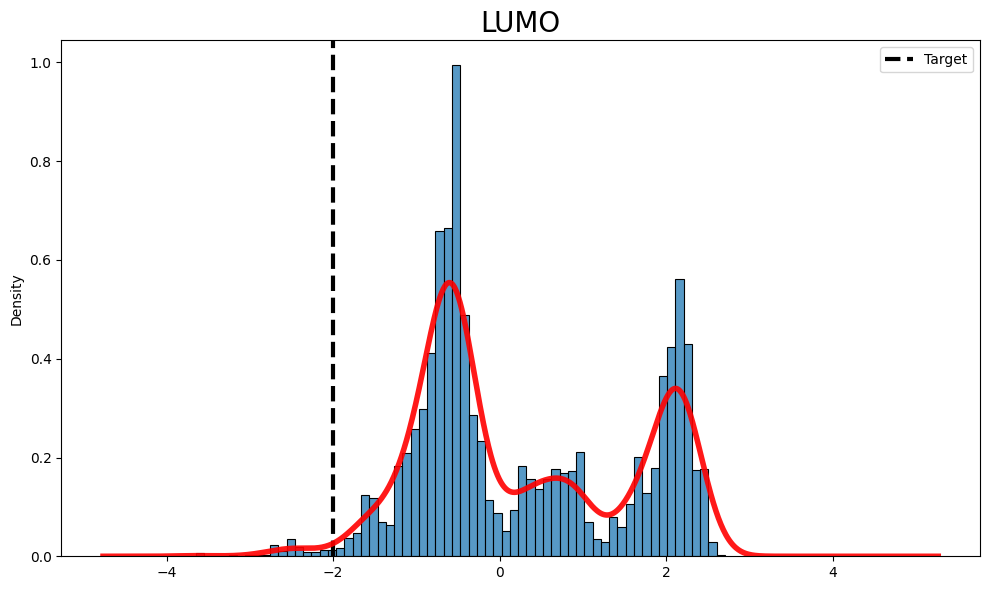

In [17]:
y_samples = torch.cat(y_sample_list, dim=0)
num_properties = len(model.properties)

fig, axes = plt.subplots(nrows=1, ncols=num_properties, figsize=(10 * num_properties, 6))
if num_properties == 1:
    axes = [axes]

density_sampled_list = []
for i, property in enumerate(model.properties):
    data = y_samples[:, i].cpu().numpy()
    kde = gaussian_kde(data)
    x_d = x_d_list[i]
    density = kde(x_d)
    density_sampled_list.append(density)
    
    sns.histplot(data, bins=64, kde=False, stat='density', ax=axes[i])
    axes[i].axvline(y_target[:, i].cpu().numpy(), color='k', linestyle='dashed', linewidth=3, label="Target")
    axes[i].plot(x_d, density, color='red', linewidth=4, alpha=0.9)
    axes[i].set_title(property.upper(), fontsize=20)
    axes[i].legend()

plt.tight_layout()
plt.show()

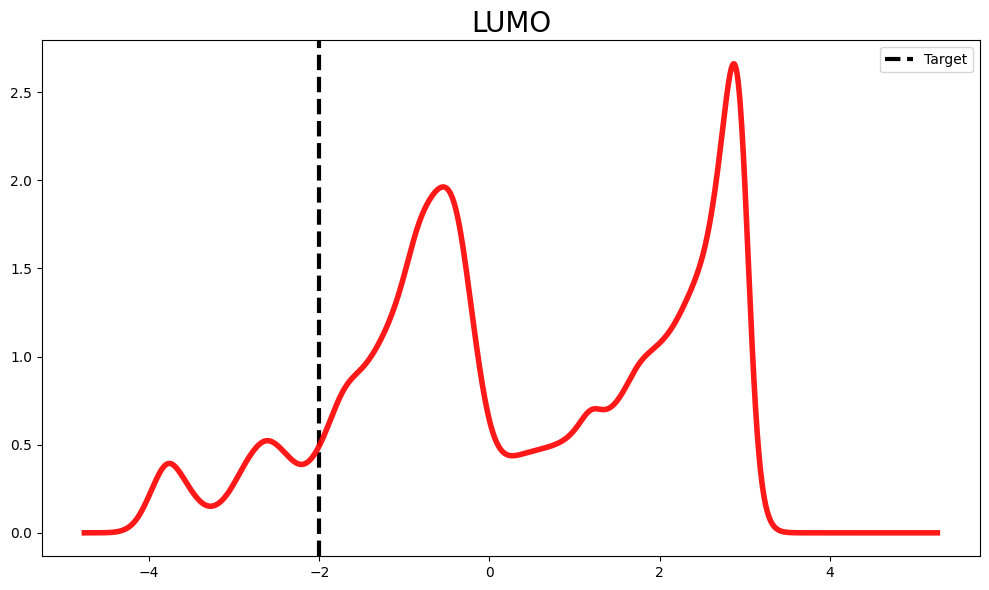

In [18]:
# plot relative density
num_properties = len(model.properties)
fig, axes = plt.subplots(nrows=1, ncols=num_properties, figsize=(10 * num_properties, 6))
if num_properties == 1:
    axes = [axes]

for i, property in enumerate(model.properties):

    x_d = x_d_list[i]
    density_dataset = density_dataset_list[i]
    density_sampled = density_sampled_list[i]
    density = density_sampled / (density_dataset + 0.001)
    
    axes[i].axvline(y_target[:, i].cpu().numpy(), color='k', linestyle='dashed', linewidth=3, label="Target")
    axes[i].plot(x_d, density, color='red', linewidth=4, alpha=0.9)
    axes[i].set_title(property.upper(), fontsize=20)
    axes[i].legend()

plt.tight_layout()
plt.show()

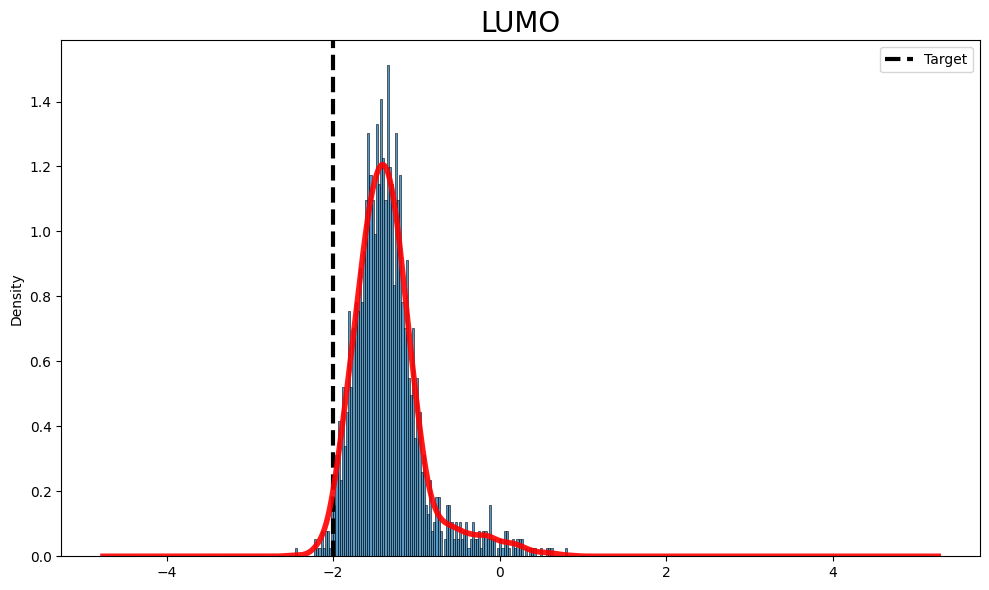

In [19]:
# plot properties predicted from posterior z

y_predicted = model.denormalize_properties(model.predict_properties(posterior_samples["z"])[0].detach())
num_properties = len(model.properties)

fig, axes = plt.subplots(nrows=1, ncols=num_properties, figsize=(10 * num_properties, 6))
if num_properties == 1:
    axes = [axes]

density_sampled_list = []
for i, property in enumerate(model.properties):
    data = y_predicted[:, i].cpu().numpy()
    kde = gaussian_kde(data)
    x_d = x_d_list[i]
    density = kde(x_d)
    density_sampled_list.append(density)
    
    sns.histplot(data, bins=128, kde=False, stat='density', ax=axes[i])
    axes[i].axvline(y_target[:, i].cpu().numpy(), color='k', linestyle='dashed', linewidth=3, label="Target")
    axes[i].plot(x_d, density, color='red', linewidth=4, alpha=0.9)
    axes[i].set_title(property.upper(), fontsize=20)
    axes[i].legend()

plt.tight_layout()
plt.show()

100%|██████████| 22/22 [00:00<00:00, 24.80it/s]


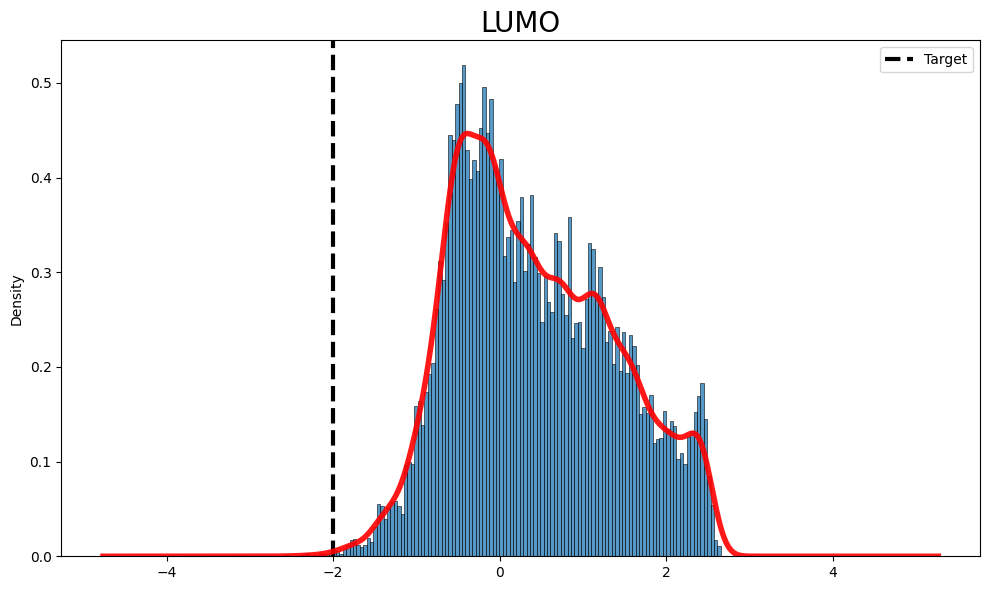

In [20]:
# predict properties of decoded molecules

generated_loader = DataLoader(dataset=generated_dataset, batch_size=1024)
y_generated_list = []
for batch in tqdm(generated_loader):
    z = model.encode_mean(batch)
    z = model.z_to_property_z(z)
    y = model.denormalize_properties(model.predict_properties(z)[0].detach())
    y_generated_list.append(y)

y_generated = torch.cat(y_generated_list, dim=0)

num_properties = len(model.properties)

fig, axes = plt.subplots(nrows=1, ncols=num_properties, figsize=(10 * num_properties, 6))
if num_properties == 1:
    axes = [axes]

density_sampled_list = []
for i, property in enumerate(model.properties):
    data = y_generated[:, i].cpu().numpy()
    kde = gaussian_kde(data)
    x_d = x_d_list[i]
    density = kde(x_d)
    density_sampled_list.append(density)
    
    sns.histplot(data, bins=128, kde=False, stat='density', ax=axes[i])
    axes[i].axvline(y_target[:, i].cpu().numpy(), color='k', linestyle='dashed', linewidth=3, label="Target")
    axes[i].plot(x_d, density, color='red', linewidth=4, alpha=0.9)
    axes[i].set_title(property.upper(), fontsize=20)
    axes[i].legend()

plt.tight_layout()
plt.show()